In [1]:
import pandas as pd
import numpy as np
testdata=pd.read_csv('data_mag.csv',header=None)
testdata=np.array(testdata)
testred=pd.read_csv('redshift.csv',header=None)
testred=np.array(testred)

In [2]:
testdata[0]

array([22.2388069 , 20.5110277 , 20.24194427, 20.1458268 , 20.11881749,
        1.7277792 ,  0.26908343,  0.09611747,  0.02700931,  2.11998941,
        0.3205355 ,  0.02898466,  0.03272481,  0.03613797,  0.1095667 ])

In [3]:
#对星等数据进行归一化
def scale_minmax(data):
    return (data-data.min())/(data.max()-data.min())

for i in range(0,15):
    testdata[:,i]=scale_minmax(testdata[:,i])

In [4]:
testdata[0]

array([3.95794090e-01, 7.22881797e-01, 4.27828383e-01, 3.03021012e-01,
       3.89454079e-01, 4.17888816e-01, 7.47999626e-01, 6.54530164e-01,
       3.59167443e-01, 4.86288924e-01, 1.14727068e-07, 6.96020597e-04,
       9.79835817e-05, 1.10148879e-08, 4.82120177e-04])

In [5]:
testred.shape

(415930, 1)

In [6]:
redshift=testred.reshape(415930,)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
import keras.backend as K
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [8]:

input_dims = 15
inputs = Input(shape=(input_dims,))
'''
attention_probs = Dense(input_dims, activation='softmax', name='attention_probs')(inputs)
attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
'''
#inputs=Flatten()(inputs)
dense1 = Dense(32, activation='relu')(inputs)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(1)(dense2)
model = Model(inputs = inputs,outputs = dense3)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
#from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.optimizers import *
# 数据集切分
(trainX, testX, trainY, testY) = train_test_split(testdata,testred, test_size=0.2, random_state=42)   

# 转换标签为one-hot encoding格式
#lb = LabelBinarizer()             
#trainY = lb.fit_transform(trainY)
#testY = lb.transform(testY)

callbacks = [EarlyStopping(patience=3), CSVLogger('model/mag.csv'), 
             ModelCheckpoint('model/tesstmag.h5', save_best_only=True,save_weights_only = False)]

model.compile(loss='mean_absolute_error',optimizer=Adam(1e-3, amsgrad=True), metrics=['mse'])

H = model.fit(trainX,trainY, epochs=100,validation_data = (testX,testY), workers=4, use_multiprocessing=True,
                      batch_size = 256, callbacks=callbacks)



Train on 332744 samples, validate on 83186 samples
Epoch 1/100
332744/332744 [==============================] - 2s 5us/step - loss: 0.4037 - mse: 0.2911 - val_loss: 0.2890 - val_mse: 0.1569
Epoch 2/100
332744/332744 [==============================] - 1s 4us/step - loss: 0.2712 - mse: 0.1465 - val_loss: 0.2651 - val_mse: 0.1387
Epoch 3/100
332744/332744 [==============================] - 1s 4us/step - loss: 0.2454 - mse: 0.1321 - val_loss: 0.2419 - val_mse: 0.1284
Epoch 4/100
332744/332744 [==============================] - 1s 4us/step - loss: 0.2332 - mse: 0.1270 - val_loss: 0.2289 - val_mse: 0.1238
Epoch 5/100
332744/332744 [==============================] - 1s 4us/step - loss: 0.2262 - mse: 0.1239 - val_loss: 0.2218 - val_mse: 0.1228
Epoch 6/100
332744/332744 [==============================] - 1s 4us/step - loss: 0.2211 - mse: 0.1213 - val_loss: 0.2181 - val_mse: 0.1197
Epoch 7/100
332744/332744 [==============================] - 1s 4us/step - loss: 0.2176 - mse: 0.1194 - val_loss: 

In [10]:
print(testY)
pred = model.predict(testX)
print(pred)

[[1.19326 ]
 [1.665689]
 [1.80627 ]
 ...
 [1.88411 ]
 [1.891038]
 [1.217254]]
[[1.2422543]
 [2.0156338]
 [1.8099496]
 ...
 [1.883821 ]
 [1.9456098]
 [1.473357 ]]


In [11]:
print(min(pred))
print(max(pred))

[-0.4353363]
[4.351351]


In [12]:
np.savetxt('prediction-mag.csv', pred, delimiter=',', fmt='%s')
np.savetxt('redshift-mag.csv', testY, delimiter=',', fmt='%s')

In [13]:
res = pred - testY
print(min(res))
print(max(res))

[-3.92741815]
[2.51461774]


In [14]:
res=np.array(res)
print(res.shape)

(83186, 1)


In [15]:
res=res.reshape(83186,)

In [16]:
#a=pd.cut(res,[-2.35,-2.25,-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65,1.75], 
#         labels=[u"(-0.3,-0.25]",u"(3,6]",u"(6,9]",u"(9,12]",u"(12,15]"])

bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]
cats = pd.cut(res, bins, right=True, duplicates='drop') #左开右闭

In [17]:
cats.value_counts()

(-2.15, -2.05]       12
(-2.05, -1.95]       16
(-1.95, -1.85]       14
(-1.85, -1.75]        5
(-1.75, -1.65]       21
(-1.65, -1.55]       21
(-1.55, -1.45]       19
(-1.45, -1.35]       29
(-1.35, -1.25]       43
(-1.25, -1.15]       66
(-1.15, -1.05]       92
(-1.05, -0.95]       83
(-0.95, -0.85]      166
(-0.85, -0.75]      267
(-0.75, -0.65]      389
(-0.65, -0.55]      564
(-0.55, -0.45]      897
(-0.45, -0.35]     1541
(-0.35, -0.25]     2920
(-0.25, -0.15]     6286
(-0.15, -0.05]    13004
(-0.05, 0.05]     17502
(0.05, 0.15]      16606
(0.15, 0.25]       9840
(0.25, 0.35]       4615
(0.35, 0.45]       2313
(0.45, 0.55]       1411
(0.55, 0.65]        960
(0.65, 0.75]        663
(0.75, 0.85]        482
(0.85, 0.95]        328
(0.95, 1.05]        306
(1.05, 1.15]        279
(1.15, 1.25]        245
(1.25, 1.35]        242
(1.35, 1.45]        196
(1.45, 1.55]        138
(1.55, 1.65]        135
(1.65, 1.75]        101
(1.75, 1.85]         89
(1.85, 1.95]         64
(1.95, 2.05]    

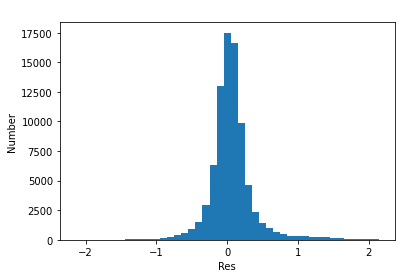

In [19]:
import pylab as pl
def draw_hist(lenths):  #lenths 接受的其实是 sizeArry传来的数组 就是def get_data(lines) 返回的数据
    data = lenths 

# 对数据进行切片，将数据按照从最小值到最大值分组，分成20组
    bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]

# 这个是调用画直方图的函数，意思是把数据按照从bins的分割来画
    pl.hist(data,bins)
#设置出横坐标
    pl.xlabel('Res')
#设置纵坐标的标题
    pl.ylabel('Number')
#设置整个图片的标题
    pl.title(' ')

# 展示出我们的图片
    pl.show()
    
draw_hist(res)

In [20]:
testY2 = testY.T
pred2 = pred.T
print(testY2.shape)
print(pred2.shape)

(1, 83186)
(1, 83186)


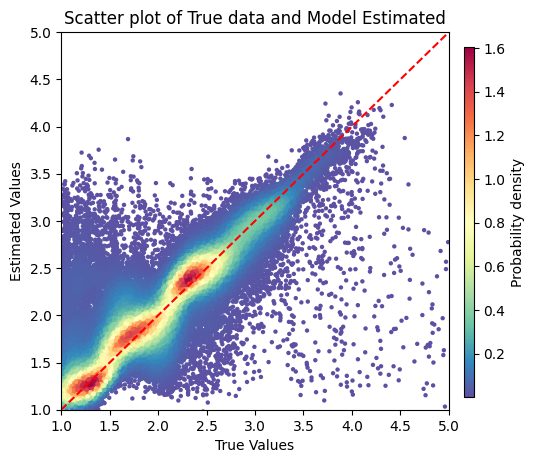

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

x2 = np.linspace(-10,10)
y2=x2
x=testY2#第一维数据
y=pred2#第二维数据
xy = np.vstack([x,y])#将两个维度的数据进行叠加
kenal = gaussian_kde(xy)#这一步根据xy这个样本数据，在全定义域上建立了概率密度分布，所以kenal其实就是一个概率密度函数，输入对应的(x,y)坐标，就给出相应的概率密度
z = kenal.evaluate(xy)#得到我们每个样本点的概率密度
z = gaussian_kde(xy)(xy)#这行代码和上面两行是相同的意思，这行是一行的写法
idx = z.argsort() #对z值进行从小到大排序并返回索引
# x, y, z = x[idx], y[idx], z[idx]#对x,y按照z的升序进行排列
#上面两行代码是为了使得z值越高的点，画在上面，不被那些z值低的点挡住，从美观的角度来说还是十分必要的
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
scatter = ax.scatter(x,y,marker='o',c=z,edgecolors='none',s=10,label='label'
                     ,cmap='Spectral_r')
cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])#[left,bottom,width,height] position
cbar = fig.colorbar(scatter, cax=cbar_ax, label='Probability density')
ax.set_xlabel('True Values')
ax.set_ylabel('Estimated Values')
ax.set_title('Scatter plot of True data and Model Estimated')
ax.set_xlim((1, 5.0))
ax.set_ylim((1, 5.0))
ax.plot(x2,y2,color='r' ,linewidth=1.5,linestyle='--')

#plt.savefig('predmag.jpg')

# -------------------------end-----------------------------

# 以上训练好的模型跑DR8数据

In [41]:
#以上训练好的模型跑DR8数据
testX8=pd.read_csv('../DR17 去除重复源/DR8/testX.csv',header=None)

In [42]:
testX8.shape

(17491, 15)

In [43]:
testX8=np.array(testX8)

In [44]:
#
pred8 = model.predict(testX8)
#

In [45]:
testY8=pd.read_csv('../DR17 去除重复源/DR8/testY.csv',header=None)

In [46]:
print(testY8)
print(pred8)

              0
0      1.782769
1      1.414872
2      2.377915
3      1.133283
4      4.096063
...         ...
17486  1.556589
17487  1.650252
17488  2.142893
17489  1.865508
17490  1.849936

[17491 rows x 1 columns]
[[2.3279722]
 [2.3597093]
 [2.7106428]
 ...
 [2.5817716]
 [2.2074223]
 [2.2903097]]


In [47]:
pred8.shape

(17491, 1)

In [48]:
testY8.shape

(17491, 1)

In [49]:
pred8.shape

(17491, 1)

In [50]:
print(min(pred8))
print(max(pred8))

[0.11169356]
[4.2337327]


In [51]:
res8 = pred8 - testY8
print(min(res8))
print(max(res8))

0
0


In [52]:
pred8 - testY8

,0
0,0.545203
1,0.944837
2,0.332728
3,1.411696
4,-0.654255
...,...
17486,0.865082
17487,0.663273
17488,0.438879
17489,0.341914


In [53]:
print(min(pred8 - testY8))
print(max(pred8 - testY8))

0
0


In [54]:
testY8_1 = testY8.T
pred8_1 = pred8.T
print(testY8_1.shape)
print(pred8_1.shape)

(1, 17491)
(1, 17491)


 ...]

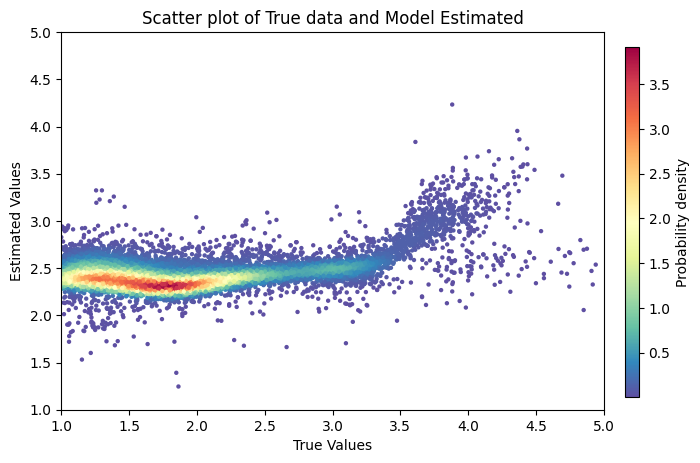

In [55]:
x2 = np.linspace(-10,10)
y2=x2
x8=testY8_1#第一维数据
y8=pred8_1#第二维数据
xy8 = np.vstack([x8,y8])#将两个维度的数据进行叠加
kenal = gaussian_kde(xy8)#这一步根据xy这个样本数据，在全定义域上建立了概率密度分布，所以kenal其实就是一个概率密度函数，输入对应的(x,y)坐标，就给出相应的概率密度
z8 = kenal.evaluate(xy8)#得到我们每个样本点的概率密度
z8 = gaussian_kde(xy8)(xy8)#这行代码和上面两行是相同的意思，这行是一行的写法
idx8 = z8.argsort() #对z值进行从小到大排序并返回索引
# x, y, z = x[idx], y[idx], z[idx]#对x,y按照z的升序进行排列
#上面两行代码是为了使得z值越高的点，画在上面，不被那些z值低的点挡住，从美观的角度来说还是十分必要的
fig, ax = plt.subplots(figsize=(7,5),dpi=100)
scatter = ax.scatter(x8,y8,marker='o',c=z8,edgecolors='none',s=10,label='label'
                     ,cmap='Spectral_r')
cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])#[left,bottom,width,height] position
cbar = fig.colorbar(scatter, cax=cbar_ax, label='Probability density')
ax.set_xlabel('True Values')
ax.set_ylabel('Estimated Values')
ax.set_title('Scatter plot of True data and Model Estimated')
ax.set_xlim((1, 5.0))
ax.set_ylim((1, 5.0))
ax.plot(x8,y8,color='r' ,linewidth=1.5,linestyle='--')

#plt.savefig('predmag.jpg')

# 加深层数

In [39]:
redshift

array([1.837838, 1.967009, 1.429148, ..., 2.490763, 2.354235, 3.146905])

In [45]:

input_dims = 15
inputs = Input(shape=(input_dims,))
'''
attention_probs = Dense(input_dims, activation='softmax', name='attention_probs')(inputs)
attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
'''
#inputs=Flatten()(inputs)
#dense1 = Dense(32, activation='relu')(inputs)
dense2 = Dense(16, activation='relu')(inputs)
dense3 = Dense(8, activation='relu')(dense2)
dense4 = Dense(4, activation='relu')(dense3)
dense5 = Dense(1)(dense4)
model1 = Model(inputs = inputs,outputs = dense5)
print(model1.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
(trainX, testX, trainY, testY) = train_test_split(testdata,testred, test_size=0.2, random_state=42)   

#callbacks = [EarlyStopping(patience=3), CSVLogger('model/mag5.csv'), 
#             ModelCheckpoint('model/tesstmag5.h5', save_best_only=True,save_weights_only = False)]

model1.compile(loss='mean_absolute_error',optimizer=Adam(1e-3, amsgrad=True), metrics=['mse'])

H1 = model1.fit(trainX,trainY, epochs=100,validation_data = (testX,testY), workers=4, use_multiprocessing=True,
                      batch_size = 512)


Train on 467205 samples, validate on 116802 samples
Epoch 1/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.4313 - mse: 0.2940 - val_loss: 0.3352 - val_mse: 0.2076
Epoch 2/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.3110 - mse: 0.1936 - val_loss: 0.2978 - val_mse: 0.1798
Epoch 3/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.2932 - mse: 0.1797 - val_loss: 0.2882 - val_mse: 0.1766
Epoch 4/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.2878 - mse: 0.1758 - val_loss: 0.2835 - val_mse: 0.1721
Epoch 5/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.2828 - mse: 0.1725 - val_loss: 0.2796 - val_mse: 0.1711
Epoch 6/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.2762 - mse: 0.1690 - val_loss: 0.2717 - val_mse: 0.1658
Epoch 7/100
467205/467205 [==============================] - 1s 3us/step - loss: 0.2713 - mse: 0.1665 - val_loss: 

# ------------------------end-----------------------------

In [55]:
print(testY)
pred1 = model1.predict(testX)
print(pred1)

[[2.495435]
 [1.980127]
 [1.800295]
 ...
 [2.394015]
 [1.723779]
 [2.353857]]
[[2.4354687]
 [1.7592846]
 [1.6655829]
 ...
 [2.2907875]
 [1.5817719]
 [2.2073967]]


In [57]:
print(min(pred1))
print(max(pred1))

[0.7176219]
[4.5242867]


In [58]:
np.savetxt('pred-test5.csv', pred1, delimiter=',', fmt='%s')
np.savetxt('redshift-test5.csv', testY, delimiter=',', fmt='%s')

In [59]:
res1 = pred1 - testY
print(min(res1))
print(max(res1))

[-3.64790088]
[2.62920062]


In [60]:
res1=np.array(res1)
print(res1.shape)

(152043, 1)


In [61]:
res1=res1.reshape(152043, )

In [62]:
#a=pd.cut(res,[-2.35,-2.25,-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65,1.75], 
#         labels=[u"(-0.3,-0.25]",u"(3,6]",u"(6,9]",u"(9,12]",u"(12,15]"])

bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]
cats = pd.cut(res1, bins, right=True, duplicates='drop') #左开右闭

In [63]:
cats.value_counts()

(-2.15, -2.05]       30
(-2.05, -1.95]       52
(-1.95, -1.85]       29
(-1.85, -1.75]       34
(-1.75, -1.65]       54
(-1.65, -1.55]       46
(-1.55, -1.45]       56
(-1.45, -1.35]      102
(-1.35, -1.25]      115
(-1.25, -1.15]      141
(-1.15, -1.05]      234
(-1.05, -0.95]      272
(-0.95, -0.85]      433
(-0.85, -0.75]      687
(-0.75, -0.65]      953
(-0.65, -0.55]     1443
(-0.55, -0.45]     2413
(-0.45, -0.35]     4090
(-0.35, -0.25]     8097
(-0.25, -0.15]    15925
(-0.15, -0.05]    26279
(-0.05, 0.05]     31442
(0.05, 0.15]      26383
(0.15, 0.25]      14252
(0.25, 0.35]       6155
(0.35, 0.45]       3066
(0.45, 0.55]       1930
(0.55, 0.65]       1240
(0.65, 0.75]       1038
(0.75, 0.85]        771
(0.85, 0.95]        588
(0.95, 1.05]        513
(1.05, 1.15]        524
(1.15, 1.25]        470
(1.25, 1.35]        460
(1.35, 1.45]        371
(1.45, 1.55]        301
(1.55, 1.65]        220
(1.65, 1.75]        196
(1.75, 1.85]        128
(1.85, 1.95]         93
(1.95, 2.05]    

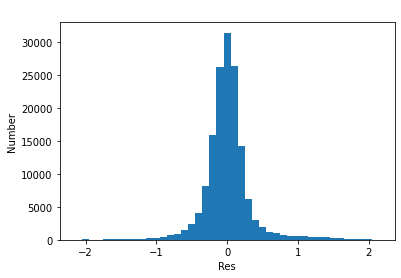

In [64]:
def draw_hist(lenths):  #lenths 接受的其实是 sizeArry传来的数组 就是def get_data(lines) 返回的数据
    data = lenths 

# 对数据进行切片，将数据按照从最小值到最大值分组，分成20组
    bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]

# 这个是调用画直方图的函数，意思是把数据按照从bins的分割来画
    pl.hist(data,bins)
#设置出横坐标
    pl.xlabel('Res')
#设置纵坐标的标题
    pl.ylabel('Number')
#设置整个图片的标题
    pl.title(' ')

# 展示出我们的图片
    pl.show()
    
draw_hist(res1)

In [65]:
testY5 = testY.T
pred5 = pred1.T
print(testY5.shape)
print(pred5.shape)

(1, 152043)
(1, 152043)


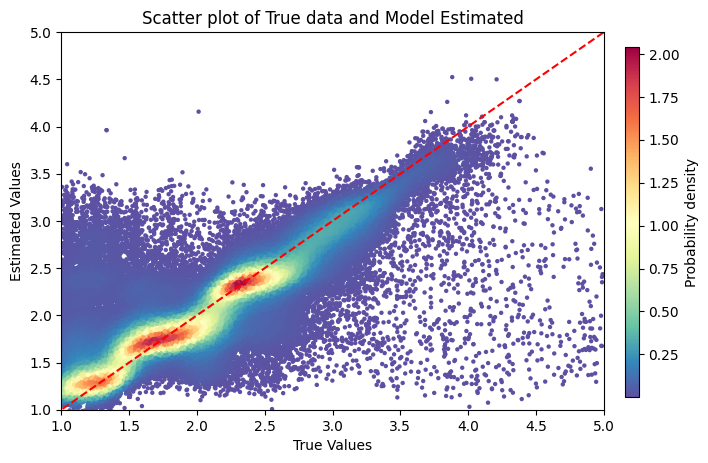

In [66]:
x2 = np.linspace(-10,10)
y2=x2
x=testY5#第一维数据
y=pred5#第二维数据
xy = np.vstack([x,y])#将两个维度的数据进行叠加
kenal = gaussian_kde(xy)#这一步根据xy这个样本数据，在全定义域上建立了概率密度分布，所以kenal其实就是一个概率密度函数，输入对应的(x,y)坐标，就给出相应的概率密度
z = kenal.evaluate(xy)#得到我们每个样本点的概率密度
z = gaussian_kde(xy)(xy)#这行代码和上面两行是相同的意思，这行是一行的写法
idx = z.argsort() #对z值进行从小到大排序并返回索引
# x, y, z = x[idx], y[idx], z[idx]#对x,y按照z的升序进行排列
#上面两行代码是为了使得z值越高的点，画在上面，不被那些z值低的点挡住，从美观的角度来说还是十分必要的
fig, ax = plt.subplots(figsize=(7,5),dpi=100)
scatter = ax.scatter(x,y,marker='o',c=z,edgecolors='none',s=10,label='label'
                     ,cmap='Spectral_r')
cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])#[left,bottom,width,height] position
cbar = fig.colorbar(scatter, cax=cbar_ax, label='Probability density')
ax.set_xlabel('True Values')
ax.set_ylabel('Estimated Values')
ax.set_title('Scatter plot of True data and Model Estimated')
ax.set_xlim((1, 5.0))
ax.set_ylim((1, 5.0))
ax.plot(x2,y2,color='r' ,linewidth=1.5,linestyle='--')